In [1]:
import os
import json

import turbodbc
import re

import pandas as pd
import numpy as np

In [2]:
with open("reuter.json") as f:
    js = json.load(f)

In [3]:
def create_connection_string_turbo(server, database):
    options = turbodbc.make_options(prefer_unicode=True)
    constr = 'Driver={ODBC Driver 13 for SQL Server};Server=' + \
        server + ';Database=' + database + ';Trusted_Connection=yes;'
    con = turbodbc.connect(connection_string=constr, turbodbc_options=options)
    return con

In [4]:
def save_extract(d, key):
    try:
        return d[key]
    except KeyError:
        return None

In [5]:
def convert_to_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

In [6]:
def transform_df(df):
    df['Artikelnummer'] = df['attribute'].apply(
        lambda x: save_extract(x, 'Artikelnummer:'))
    df['Serie'] = df['attribute'].apply(
        lambda x: save_extract(x, 'Serie:'))
    
    df['Preis'] = df['price'].replace(
        '[^0-9.,]', '', regex=True).replace(
        '\,', '.', regex=True).apply(
            lambda x: str(x)[:-1] if str(
                x).endswith('.')  else str(x)).apply(
        lambda x: convert_to_float(x)).astype("float")
    
    df = df.drop(['attribute', 'price'], axis=1)
    df.columns = ['Bezeichnung', 'Lieferant',
                  'Artikelnummer', 'Serie', 'Preis']
    return df

In [7]:
def clean_id(df, colname, colname_new):
    df[colname_new] = df[colname].str.replace("[^0-9a-zA-Z]|\.", "")
    return df

In [8]:
df = (pd.DataFrame(js)
        .pipe(transform_df)
        .pipe(clean_id, "Artikelnummer", "Artikelnummer_clean"))

In [9]:
df.head()

,Bezeichnung,Lieferant,Artikelnummer,Serie,Preis,Artikelnummer_clean
0,Grohe Minta Spültischbatterie mit herausziehba...,Grohe,30274000,Minta,171.0,30274000
1,Buderus Logatrend Flachheizkörper-Ventil-Kompa...,Buderus,7750200104,Logatrend,67.0,7750200104
2,HSK Image Badheizkörper weiß,HSK,8166172-04,Image,399.0,816617204
3,Kermi Casteo Ventilhahnblock-Set weiß,Kermi,ZV01200001,Casteo,67.0,ZV01200001
4,AEG Thermo Boden Comfort TURBO Set TBS TC 30 2...,AEG Haustechnik,234357,Thermo Boden Comfort TURBO,506.0,234357


In [10]:
query = """
set nocount on;

SELECT  [Artikelnummer]
      ,[Artikel Beschreibung]
      ,[Lieferantenname]
      ,[Bruttoverkauf]
      ,[Standardkosten]
      ,[Lieferantennummer]
into #temp
FROM [AnalystCM].[dbo].[LOOKUP_ArtikelstammCRHT]
where Artikelgruppe between 5000 and 5999 and [Einmalartikel (J/N)] = 0 and [Artikel Status] = '02'

select idItemOrigin
,AvgPrice = Avg(Sales / case when Quantity = 0 then NULL else Quantity end)
,WAvgPrice = sum(Sales) / case when sum(Quantity) = 0 then NULL else sum(Quantity) end
into #avgprice
from crhbusadwh01.infopool.fact.sales
where date > dateadd(month,-12, getdate())
group by idItemOrigin

select [Artikelnummer]
      ,[Artikel Beschreibung]
      ,[Lieferantenname]
      ,[Bruttoverkauf]
      ,[Standardkosten]
      ,[ArtikelnummerLieferant] = [Lieferantennummer]
      ,Durchschnittspreis = AvgPrice
      ,GDurchschnittspreis = WAvgPrice
from #temp t
    left join #avgprice a on t.Artikelnummer = a.idItemOrigin collate Latin1_General_CI_AS

drop table #temp
drop table #avgprice
"""

In [11]:
con = create_connection_string_turbo("CRHBUSADWH51", "Operations")
df_server = pd.read_sql(query, con)
df_server['Bruttoverkauf'] = df_server['Bruttoverkauf'].astype("float")
df_server['Standardkosten'] = df_server['Standardkosten'].astype("float")

In [12]:
df_server = df_server.pipe(clean_id,
                           "ArtikelnummerLieferant",
                           "ArtikelnummerLieferant_clean")

In [13]:
df_merged = df.merge(df_server,
                     left_on="Artikelnummer_clean",
                     right_on="ArtikelnummerLieferant_clean",
                     how="left",
                     suffixes=['_Reuter', '_CRH'])

In [14]:
change = 1.15

In [15]:
preis_col = 'Preis_Reuter_CHF ({})'.format(change)

In [16]:
df_merged[preis_col] = df_merged['Preis'] * change

In [17]:
df_merged = df_merged[['Artikelnummer_Reuter','Artikelnummer_clean', 'Lieferant',
                       'Bezeichnung', 'Preis',preis_col,
                       'Serie', 'Artikelnummer_CRH', 'Artikel Beschreibung',
                       'Lieferantenname', 'Bruttoverkauf',
                       'Standardkosten', 'Durchschnittspreis','GDurchschnittspreis']]

In [18]:
from matplotlib import pyplot
import seaborn as sns

In [19]:
df_merged['Diff'] = df_merged[preis_col] - df_merged['GDurchschnittspreis']

In [20]:
limit = 100
df_diff = df_merged[~pd.isna(df_merged['Diff'])]
df_diff = df_diff[(df_diff['Diff'] > -limit) & (df_diff['Diff'] < limit)]

In [21]:
grouped = df_diff.groupby('Lieferant', as_index=False)['Diff'].median()
grouped['Check'] = grouped['Diff'] > 0

In [22]:
df_diff = df_diff.merge(grouped[['Lieferant', 'Check']], how="left", left_on="Lieferant", right_on="Lieferant")

In [23]:
df_diff.head()

,Artikelnummer_Reuter,Artikelnummer_clean,Lieferant,Bezeichnung,Preis,Preis_Reuter_CHF (1.15),Serie,Artikelnummer_CRH,Artikel Beschreibung,Lieferantenname,Bruttoverkauf,Standardkosten,Durchschnittspreis,GDurchschnittspreis,Diff,Check
0,27281000,27281000,Hansgrohe,"Hansgrohe Crometta E 240 1jet Showerpipe, EcoS...",267.00,307.0500,Crometta E,7003375,"Duschsystem CROMETTA E 240\1JET, EcoSmart, Dus...",Hansgrohe AG,692.0,318.86,355.750333,354.357429,-47.307429,False
1,115882KJ1,115882KJ1,Geberit,Geberit Sigma20 Betätigungsplatte für 2-Mengen...,42.00,48.3000,Sigma20,6944541,Abdeckplatte SIGMA20\Zweimengenbetätigung von ...,Geberit Vertriebs AG,78.0,42.19,40.488273,40.333323,7.966677,True
2,115882KJ1,115882KJ1,Geberit,Geberit Sigma20 Betätigungsplatte für 2-Mengen...,42.49,48.8635,Sigma20,6944541,Abdeckplatte SIGMA20\Zweimengenbetätigung von ...,Geberit Vertriebs AG,78.0,42.19,40.488273,40.333323,8.530177,True
3,5656HRR1,5656HRR1,Villeroy & Boch,"Villeroy & Boch Avento Wand-Tiefspül-WC, Direc...",323.00,371.4500,Avento,6993293,"Wandklosett AVENTO UP\Combi-Pack, bestehend au...",Villeroy & Boch AG/LSV,766.0,328.61,423.770000,423.770000,-52.320000,False
4,115882KN1,115882KN1,Geberit,Geberit Sigma20 Betätigungsplatte für 2-Mengen...,64.21,73.8415,Sigma20,6944543,Abdeckplatte SIGMA20\Zweimengenbetätigung von ...,Geberit Vertriebs AG,112.0,60.48,58.402394,59.153500,14.688000,True


In [24]:
sort_sup = df_diff.groupby('Lieferant')['Diff'].median().sort_values().index

In [25]:
my_pal = df_diff[['Lieferant', 'Check']].copy().drop_duplicates()
my_pal['Check'] = my_pal['Check'].map({False: "#e67e22", True: "#2980b9"})

In [26]:
my_pal = {i[1]['Lieferant']: i[1]['Check'] for i in my_pal.iterrows()}

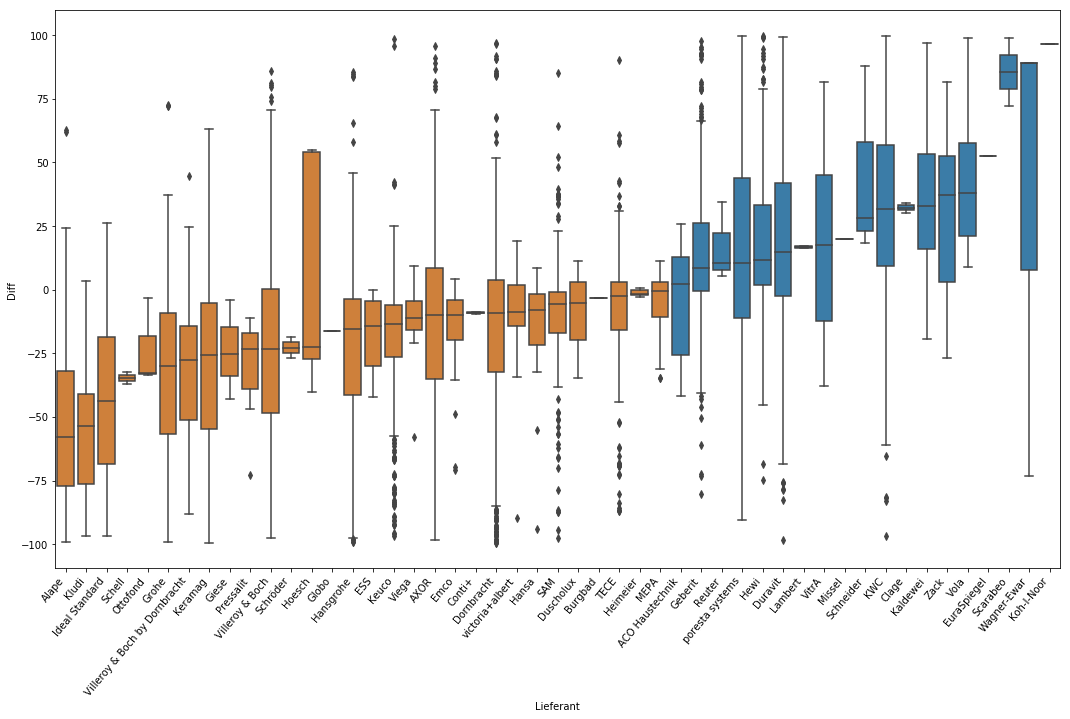

In [29]:
a4_dims = (18, 10.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
sns.boxplot(ax=ax, x='Lieferant', y='Diff', palette=my_pal,
            data=df_diff, order=sort_sup)
fig.savefig("Preisvergleich.pdf")

In [28]:
df_merged.to_excel("reuter.xlsx", index=False)
df_merged[~pd.isna(df_merged['Artikelnummer_CRH'])].to_excel("reuter_matched.xlsx", index=False)

In [34]:
df_supplier_match = df_merged[(df_merged['Lieferant'].fillna('')>'') & (df_merged['Lieferantenname'].fillna('')>'')]

In [37]:
df_supplier_match[['Lieferant', 'Lieferantenname']].drop_duplicates().to_clipboard()